This is just following the islp tree lab on a decent chunk of the code segments used.

Lab link is [Islp Trees Lab](https://nbviewer.org/urls/websites.umich.edu/~yuekai/datasci415/assets/nb/Ch08-baggboost-lab.ipynb)

In [1]:
pip install ISLP

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 5.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=58164d4e5473bbd137edf7a089474f71b9a9ed1cded7c270d53e82b4d22b0391
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting un

In [2]:
# imports from the islp lab
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)


In [3]:
data = pd.read_csv("full_dataset.csv")


Using the decision tree classifier to predict winner 2020 with basically all the predictors

In [4]:
# one hot encoding state
data = pd.get_dummies(data, prefix=["State"], columns=["State"], drop_first=True)


In [5]:
# setup for making a model
model = MS(data.columns.drop(['County','county_fips', 'prop_favored_dem_2020','winner_2020','county_names_with_casing']), intercept=False)
D = model.fit_transform(data)
feature_names = list(D.columns)
winner = data[["winner_2020"]].values.ravel()
X = np.asarray(D)




In [6]:
# split the data into a train and test set
(X_train,
X_test,
y_train,
y_test) = skm.train_test_split(X,
                                   winner,
                                   test_size=0.2,
                                   random_state=0)

In [7]:
# no max depth is given, as that is found through cross validation
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

0.9713375796178344

test accuracy of 97% without pruning without election results

In [8]:
# making a tree with pruning
ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)

This yields a set of impurities and $\alpha$
 values from which we can extract an optimal one by cross-validation.

In [9]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_score_

0.9812637450199203

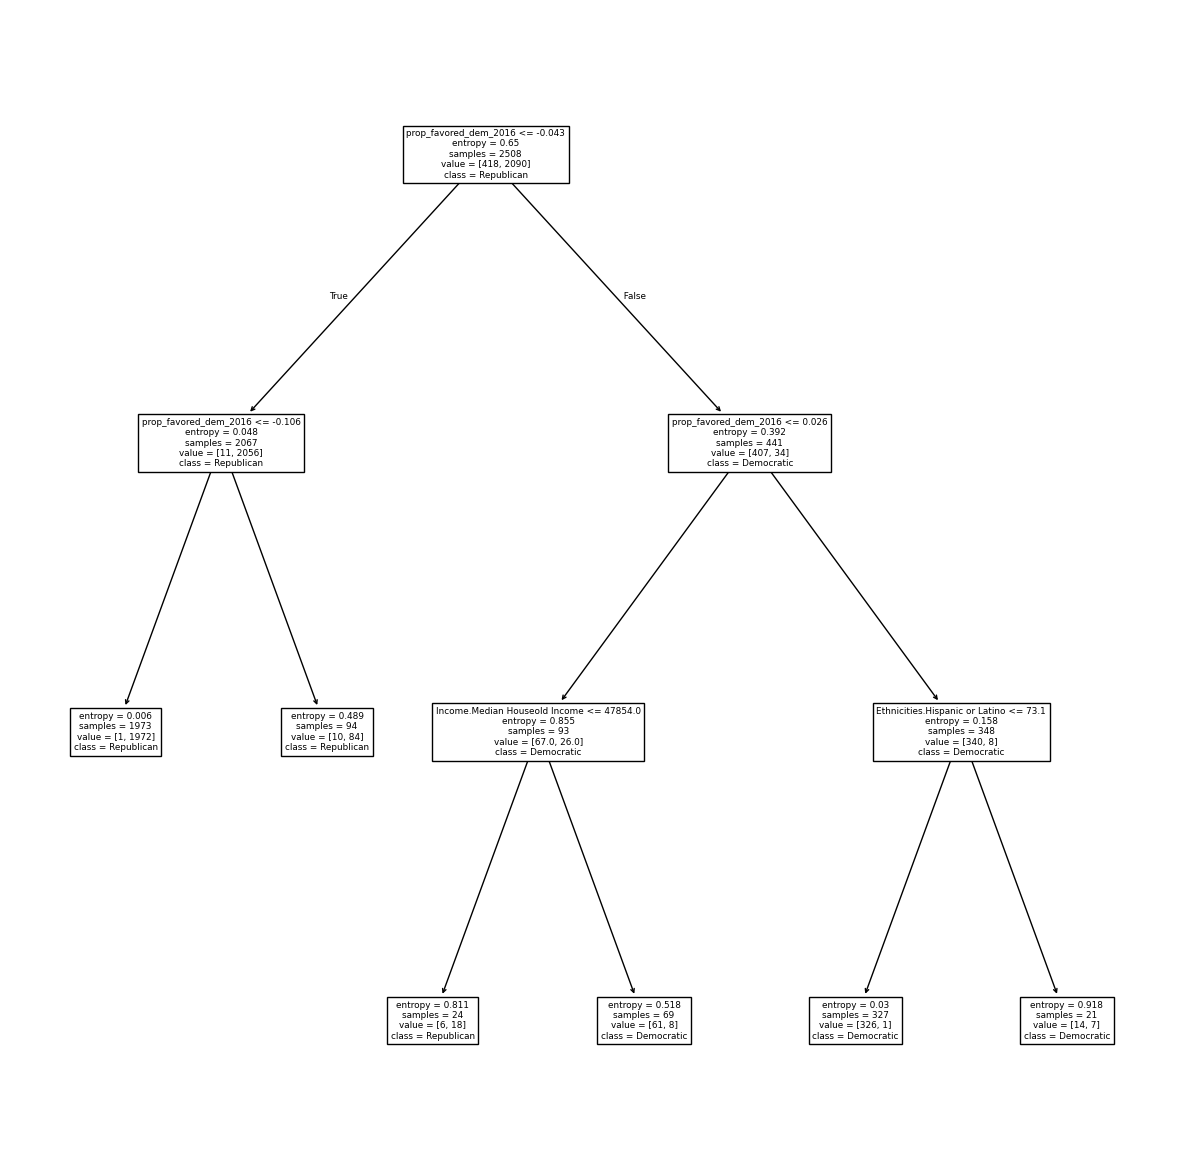

In [10]:
ax = subplots(figsize=(15,15))[1] # the figsize needs to be increased to make them readable
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax, class_names = ["Democratic","Republican"]);


In [11]:
print(export_text(best_,
                  feature_names=feature_names,
                  show_weights=True))

|--- prop_favored_dem_2016 <= -0.04
|   |--- prop_favored_dem_2016 <= -0.11
|   |   |--- weights: [1.00, 1972.00] class: Republican
|   |--- prop_favored_dem_2016 >  -0.11
|   |   |--- weights: [10.00, 84.00] class: Republican
|--- prop_favored_dem_2016 >  -0.04
|   |--- prop_favored_dem_2016 <= 0.03
|   |   |--- Income.Median Houseold Income <= 47854.00
|   |   |   |--- weights: [6.00, 18.00] class: Republican
|   |   |--- Income.Median Houseold Income >  47854.00
|   |   |   |--- weights: [61.00, 8.00] class: Democrat
|   |--- prop_favored_dem_2016 >  0.03
|   |   |--- Ethnicities.Hispanic or Latino <= 73.10
|   |   |   |--- weights: [326.00, 1.00] class: Democrat
|   |   |--- Ethnicities.Hispanic or Latino >  73.10
|   |   |   |--- weights: [14.00, 7.00] class: Democrat



This tree does impy to have at least a bit more nuance and interaction of features than the first tree did

This does kind of imply doing the interesting problem Tom had, which is just not using prop favored in prediction at all, to see how well it can do then, and which other features shine.

In [12]:
best_.tree_.n_leaves


6

Our tree only has 6 leaves and 5 rules

In [13]:
# on test data
print(accuracy_score(y_test,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            y_test)
confusion

0.9729299363057324


Truth,Democrat,Republican
Predicted,,
Democrat,118,5
Republican,12,493


So most counties go republican anyways, at least in this test set, but it does still seem to have a really good accuracy on democrat counties